<a href="https://colab.research.google.com/github/jscienciadados/regularizacao-lasso-ridge/blob/main/Regularizacao_Lasso_Ridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Regularização - Regressão Lasso e Ridge**

Existem 2 métodos principais para regularização de um modelo de regressão linear: Regressão LASSO e Regressão Ridge. A Regressão Ridge é basicamente um modelo de regressão linear regularizado. O parâmetro λ é um escalar que também deve ser aprendido, usando um método chamado validação cruzada (cross validation).

Matematicamente, a Regressão Ridge estima uma função de regressão múltipla definida como:

A Regressão Ridge aplica restrição nos coeficientes (w). O termo de penalidade (lambda) regulariza os coeficientes de forma que, se os coeficientes assumem valores grandes, a função de otimização é penalizada. Portanto, a Regressão Ridge reduz os coeficientes e ajuda a reduzir a complexidade e a multicolinearidade do modelo. Quando λ → 0, a função de custo se torna semelhante à função de custo de regressão linear. Ou seja, diminuindo a restrição (λ baixo) nos recursos, o modelo se parecerá com o modelo de regressão linear.

A Regressão LASSO é um método de seleção de variáveis e encolhimento para modelos de regressão linear. O objetivo da Regressão LASSO é obter o subconjunto de preditores que minimiza o erro de previsão para uma variável de resposta quantitativa. O algoritmo faz isso impondo uma restrição nos parâmetros do modelo que faz com que os coeficientes de regressão de algumas variáveis convirjam em direção a zero.

Variáveis com um coeficiente de regressão igual a zero após o processo de restrição são excluídas do modelo. Portanto, quando você trabalhar um modelo de regressão, pode ser útil fazer uma Regressão LASSO para prever quantas variáveis seu modelo deve conter. Isso garante que seu modelo não seja excessivamente complexo e evita que o modelo se ajuste demais, o que pode resultar em um modelo tendencioso e ineficiente.

A única diferença da Regressão LASSO para a Regressão Ridge é que o termo de regularização está em valor absoluto. Mas essa diferença tem um enorme impacto. O método LASSO supera a desvantagem da Regressão Ridge, punindo não apenas os altos valores dos coeficientes β, mas definindo-os como zero se não forem relevantes. Portanto, você pode acabar com menos recursos incluídos no modelo em relação ao que começou, o que é uma grande vantagem.

Matematicamente, a Regressão LASSO estima uma função de regressão múltipla definida como:

## Dataset:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

http://jse.amstat.org/v19n3/decock.pdf

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



In [2]:
# Montando o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Verificando o drive
import os
os.chdir("/content/drive/")
!ls

MyDrive


## Carregando Os Dadso

In [6]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/datasets/treino.csv')
test = pd.read_csv('/content/drive/MyDrive/datasets/teste.csv')

In [7]:
# Shape do Dados de treino
train.shape

(1460, 81)

## Criando um dataset com  todos os dados

In [8]:
# Visualizando todos os dados
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
all_data.head(10)



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Gd,Y,FuseF,1022,752,0,1774,0.0,0.0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,

## Análise Exploratória de Dados

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5cf4952b50>,
      dtype=object)

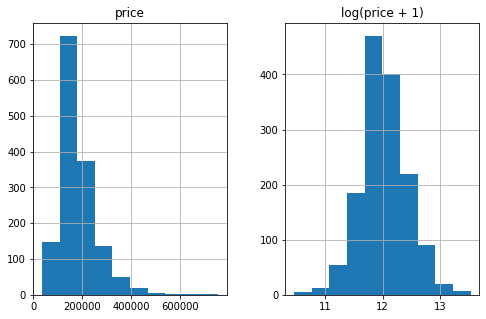

In [9]:
# Pré-Processamento dos dados
new_price = {"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])}
prices = pd.DataFrame(new_price)
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
prices.hist()



## Transformação de Logs

In [10]:
# Log transform da variável target e remoção dos valores NA
train["SalePrice"] = np.log1p(train["SalePrice"])
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [11]:
# Aplicação das transformações a todos os dados e nova divisão em treino e teste
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

# Nova divisão em dados de treino e de teste
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

In [12]:
# Função para calcular o RMSE
def rmse_cv(modelo):
    rmse = np.sqrt(-cross_val_score(modelo,
                                    X_train,
                                    y_train,
                                    scoring = "neg_mean_squared_error",
                                    cv = 5))
    return(rmse)



## Modelo de Regressão Linear Múltipla (Sem Regularização)

In [13]:
# Criando um modelo
modelo_lr = LinearRegression(normalize = False, fit_intercept = True)



In [14]:
# Treinando o modelo com dados não padronizados (em escalas diferentes)
modelo_lr.fit(X_train, y_train)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# Erro médio do modelo
rmse_cv(modelo_lr).mean()



0.16524087909051494

## O Objetivo da Regularização é minimizar o erro do modelo -> quanto menor melhor significa que o modelo generaliza bem o aprendizado.

## Modelo de Regressão Ridge

In [16]:
# Cria o Modelo Lasso()
modelo_ridge = Ridge()

In [17]:
# Cross Validation para encontrar os melhores valores dos parâmetros do modelo Ridge
cross_val_score(modelo_ridge,
                X_train,
                y_train,
                scoring = "neg_mean_squared_error",
                cv = 5)



array([-0.01295836, -0.01925459, -0.01876047, -0.01252866, -0.02412218])

In [18]:
# Calcula o erro do modelo
rmse_ridge = np.sqrt(-cross_val_score(modelo_ridge,
                                      X_train,
                                      y_train,
                                      scoring = "neg_mean_squared_error",
                                      cv = 5))
rmse_ridge

array([0.11383481, 0.13876091, 0.13696888, 0.11193148, 0.15531317])

In [19]:
# Valores de alpha para testar com o modelo Ridge
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]



Text(0, 0.5, 'RMSE')

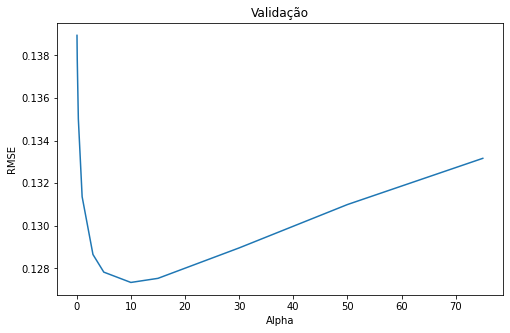

In [20]:
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validação")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

In [21]:
# Erro médio do modelo
cv_ridge.mean()

0.13159475841045756

## Modelo de Regressão LASSO

In [22]:
# Cria o modelo LASSO
modelo_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)



In [23]:
# Erro médio do modelo
rmse_cv(modelo_lasso).mean()



0.12256735885048142

In [24]:
# Coeficientes LASSO
coef = pd.Series(modelo_lasso.coef_, index = X_train.columns)
coef.head()

MSSubClass    -0.007480
LotFrontage    0.000000
LotArea        0.071826
OverallQual    0.053160
OverallCond    0.043027
dtype: float64

Text(0.5, 1.0, 'Coeficientes no Modelo LASSO')

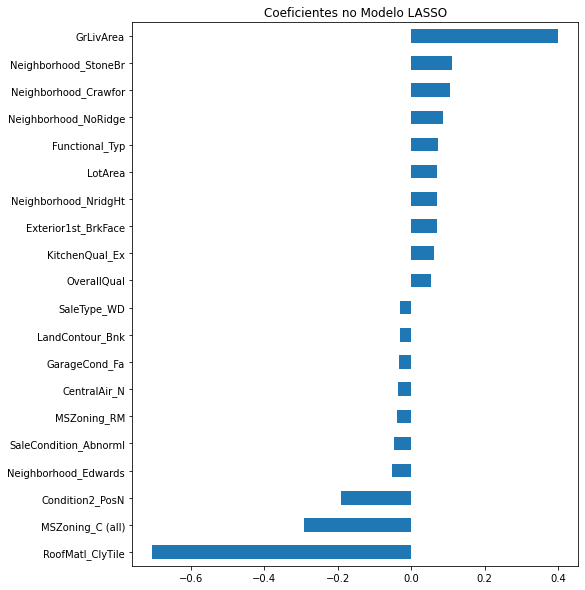

In [25]:
# Coeficientes LASSO mais relevantes e menos relevantes para o modelo
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coeficientes no Modelo LASSO")

